# Tutorial 2: Integrating Multi-slices 
This tutorial demonstrates STABox-STAligner’s ablility to integrate Multi-slices and support minibatch training to reduce GPU memory.

Here, We use the Mouse Embryo data generated by Stereo-seq . The Stereo-seq data can be downloaded from https://db.cngb.org/stomics/mosta/download.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import torch
from stabox.model._utils import Stats_Spatial_Net
from stabox.model import STAligner
import glob
from scipy.sparse import issparse, csr_matrix
from stabox.pl.utils import Cal_Spatial_Net_new
import anndata as ad
import scipy.linalg

D:\Users\lqlu\work\software\Anaconda\envs\new_STABox_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [3]:
path = 'D:/Users/lqlu/work/Data/STABox_Data/Stereo-seq'

In [4]:
Batch_list = []
adj_list = []
section_ids = ['E9.5_E1S1', 'E10.5_E1S1']

for section_id in section_ids:
    adata = sc.read(os.path.join(path,f'{section_id}.MOSTA.h5ad'))
    adata.var_names_make_unique(join="++")

    # read the annotation
#     Ann_df = pd.read_csv(os.path.join(path, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
#     Ann_df.columns = ['Ground Truth']
#     Ann_df[Ann_df.isna()] = "unknown"
#     adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')
    
    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]
    
    # Constructing the spatial network
    Cal_Spatial_Net_new(adata, rad_cutoff=1.3) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
    
    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

Only considering the two last: ['.MOSTA', '.h5ad'].
Only considering the two last: ['.MOSTA', '.h5ad'].
------Calculating spatial graph...


D:\Users\lqlu\work\Codes\work\STABox\src\stabox\pl\utils.py:632: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
D:\Users\lqlu\work\Codes\work\STABox\src\stabox\pl\utils.py:633: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)


The graph contains 23166 edges, 5913 cells.
3.9178 neighbors per cell on average.


D:\Users\lqlu\work\software\Anaconda\envs\new_STABox_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


Only considering the two last: ['.MOSTA', '.h5ad'].
Only considering the two last: ['.MOSTA', '.h5ad'].
------Calculating spatial graph...


D:\Users\lqlu\work\Codes\work\STABox\src\stabox\pl\utils.py:632: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
D:\Users\lqlu\work\Codes\work\STABox\src\stabox\pl\utils.py:633: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)


The graph contains 72822 edges, 18408 cells.
3.9560 neighbors per cell on average.


D:\Users\lqlu\work\software\Anaconda\envs\new_STABox_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


In [5]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
adata_concat.uns['edge_list'] = adj_list
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (24321, 636)


In [6]:
staligner = STAligner(model_dir="D:/Users/lqlu/work/Data/STABox_Data/0X_Data/DLPFC/Multi-Slices", in_features=636, hidden_dims=[512, 30])

In [7]:
staligner.train_minibatch(adata_concat, knn_neigh=100, margin=2.5)

D:\Users\lqlu\work\software\Anaconda\envs\new_STABox_env\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


STAGateModule(
  (conv1): GATConv(636, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 636, heads=1)
)
Pretrain with STAGATE...[(0, 1)]


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:36<00:00,  6.91it/s]


Train with STAligner...[(0, 1)]


  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

Update spot triplets at epoch 0


 40%|████████████████████████████████                                                | 100/250 [00:28<00:35,  4.22it/s]

Update spot triplets at epoch 100


 80%|████████████████████████████████████████████████████████████████                | 200/250 [01:03<00:12,  3.88it/s]

Update spot triplets at epoch 200


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:28<00:00,  2.84it/s]


AnnData object with n_obs × n_vars = 24321 × 636
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - Arid3a', 'Regulon - Arx', 'Regulon - Atf4', 'Regulon - Atf6', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Bcl11a', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bmyc', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Chd1', 'Regulon - Clock', 'Regulon - Creb1', 'Regulon - Creb3', 'Regulon - Crem', 'Regulon - Crx', 'Regulon - Ctcf', 'Regulon - Cux1', 'Regulon - Dbx1', 'Regulon - Dbx2', 'Regulon - Dlx4', 'Regulon - Dlx5', 'Regulon - Dlx6', 'Regulon - E2f1', 'Regulon - E2f2', 'Regulon - E2f3', 'Regulon - E2f4', 'Regulon - E2f5', 'Regulon - E2f6', 'Regulon - E2f7', 'Regulon - E2f8', 'Regulon - Ebf1', 'Regulon - Egr2', 'Regulon - Egr4', 'Regulon - Elf1', 'Regulon - Elf2', 'Regulon - Elk1', 'Regulon - Elk3', 'Regulon - Emx2', 'Regulon - En1', 'R

In [8]:
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [9]:
louvain_resolution = 0.6
sc.tl.louvain(adata_concat, random_state=666, key_added="louvain", resolution=louvain_resolution)

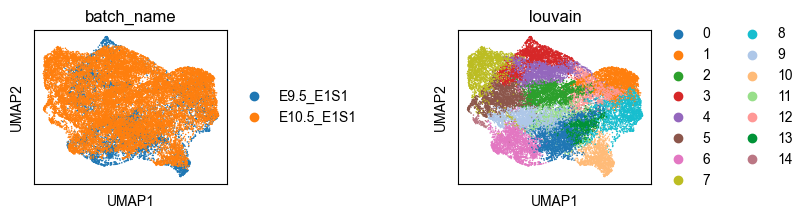

D:\Users\lqlu\work\software\Anaconda\envs\new_STABox_env\lib\site-packages\ipykernel_launcher.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


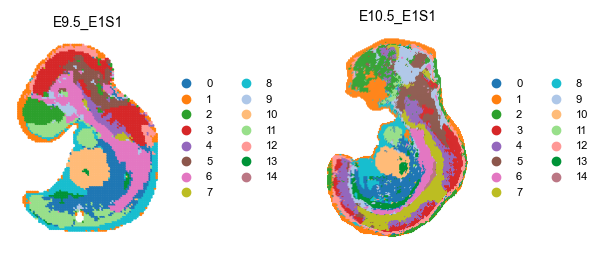

In [10]:
colors_default = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                  '#8c564b', '#e377c2', '#bcbd22', '#17becf', '#aec7e8',
                  '#ffbb78', '#98df8a', '#ff9896', '#009337', '#bb7784',
                  '#0000ff', '#7e1e9c', '#ff028d', '#aaff32', '#ff000d',
                  '#89a203', '#26f7fd', '#fdb147', '#b7c9e2', '#ae7181',
                  '#c7fdb5', '#cd416b', '#001146', '#06470c', '#000000',
                  '#e50000', '#95d0fc', '#89fe05', '#bf77f6', '#00035b',
                  '#d1b26f', '#13eac9', '#06c2ac', '#06470c', '#35063e']

adata_concat.uns['louvain_colors'] = [colors_default[0:][i] for i in np.sort(adata_concat.obs['louvain'].unique().astype('int'))]

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 10

sc.pl.umap(adata_concat, color=['batch_name', 'louvain'], ncols=2, wspace=1, show=True)



for ss in range(len(section_ids)):
    Batch_list[ss].obs['louvain'] = adata_concat[adata_concat.obs['batch_name'] == section_ids[ss]].obs['louvain'].values
    Batch_list[ss].uns['louvain_colors'] = [colors_default[0:][i] for i in np.sort(adata_concat[adata_concat.obs['batch_name'] ==
                                                                            section_ids[ss]].obs['louvain'].unique().astype('int'))]

import matplotlib.pyplot as plt
spot_size = 1
title_size = 10
fig, ax = plt.subplots(1, len(section_ids), figsize=(len(section_ids)*3, 3), gridspec_kw={'wspace':1, 'hspace': 0.1})
for ss in range(len(section_ids)-1):
    _sc_0 = sc.pl.spatial(Batch_list[ss], img_key=None, color=['louvain'], title=['louvain'], size=1.5, legend_fontsize=8,
                  show=False, frameon=False, ax=ax[ss], spot_size=spot_size)
    _sc_0[0].set_title(section_ids[ss], size=title_size)
_sc_0 = sc.pl.spatial(Batch_list[-1], img_key=None, color=['louvain'], title=['louvain'], size=1.5, legend_fontsize=8,
              show=False, frameon=False, ax=ax[-1], spot_size=spot_size)
_sc_0[0].set_title(section_ids[-1], size=title_size)
plt.show()